In [1]:
#import libraries
import streamlit as st

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import time, date, datetime
import openpyxl
from openpyxl import Workbook

import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

## A. Data Wrangling

**Raw CFU** file is a template. To write a function:
- skiprows=2
- key: 'Batch' col
- features: [Sample description],'Storage form','Temperature-Celsius','T0','Date','CFU/mL','CFU/g','CV' (?),'Water Acitivty' cols
- remove rows with NaN in 'Batch' col
- Change 'Batch' col to 'FD Run ID'

- Change to datetime for "Date, T0"
- Change to float/number for "CFU/mL, CFU/g, CV": fix DIV/0 to NaN

In [3]:
# Import the dataset
rawcfu_df = pd.read_csv(filepath_or_buffer="Data files/Pivot_CFUs_Template.csv")
rawcfu_df.head()

,"Sparkle PIVOT Sample CFU plating data recording sheet. Manually enter your data in columns marked with a ⭐ (optional: †) and the other columns should auto-calculate appropriately. The data are sortable, and can be filtered using the dropdowns in each column.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,⭐,⭐,†,†,†,⭐,†,⭐,NaN,⭐,...,†,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭐
1,Batch,Sample Description,Storage form,Temperature-Celsius,Logs,No. Reps,Extra,grams,mL,Who,...,R3,CFU/mL,SD CFU/mL,Extender CFU/mL,Extender CFU/mL SD,CFU/g,SD CFU/g,CV,Water Activity,Remark/AW
2,IFF09152022-2 T1,NaN,NaN,21,"5, 6",3,NaN,0.3,5.7,EC,...,172,7.41E+08,6.38E+07,NaN,NaN,1.41E+10,1.21E+09,8.60%,0.254,"SP-SDS, Water Activity= 0.254"
3,IFF09152022-2 T2,NaN,NaN,21,"5, 6",3,NaN,0.3,5.7,EC,...,46,1.97E+09,1.97E+08,NaN,NaN,3.75E+10,3.75E+09,10.00%,0.198,"SP-SDS, Water Activity= 0.198"
4,IFF09152022-2 T3,NaN,NaN,4,"6, 7",3,NaN,0.3,5.7,EC,...,35,1.25E+10,2.54E+09,NaN,NaN,2.38E+11,4.83E+10,20.30%,NaN,Redo


In [4]:
# replace the colmns with the values of the second row
rawcfu_df.columns = rawcfu_df.iloc[1]

# remove the first and second rows
rawcfu_df = rawcfu_df.iloc[2:]

# reset index
rawcfu_df = rawcfu_df.reset_index()

# keep relevant cols
rawcfu_df = rawcfu_df[['Batch','Sample Description','Storage form','Temperature-Celsius',
                       'T0','Date','CFU/mL','CFU/g','Extender CFU/mL','Extender CFU/mL SD',
                       'CV','Water Activity']]

rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,Extender CFU/mL,Extender CFU/mL SD,CV,Water Activity
0,IFF09152022-2 T1,NaN,NaN,21,1/5/23,2/27/23,7.41E+08,1.41E+10,NaN,NaN,8.60%,0.254
1,IFF09152022-2 T2,NaN,NaN,21,1/5/23,2/27/23,1.97E+09,3.75E+10,NaN,NaN,10.00%,0.198
2,IFF09152022-2 T3,NaN,NaN,4,1/5/23,2/27/23,1.25E+10,2.38E+11,NaN,NaN,20.30%,NaN
3,IFF09152022-2 T3,NaN,NaN,4,1/5/23,3/1/23,2.30E+01,4.50E+00,NaN,NaN,8.60%,NaN
4,IFF09152022-2 T4,NaN,NaN,21,1/5/23,2/27/23,4.55E+08,8.64E+09,NaN,NaN,7.90%,0.267


In [5]:
rawcfu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Batch                72 non-null     object
 1   Sample Description   13 non-null     object
 2   Storage form         23 non-null     object
 3   Temperature-Celsius  17 non-null     object
 4   T0                   72 non-null     object
 5   Date                 72 non-null     object
 6   CFU/mL               71 non-null     object
 7   CFU/g                72 non-null     object
 8   Extender CFU/mL      9 non-null      object
 9   Extender CFU/mL SD   9 non-null      object
 10  CV                   72 non-null     object
 11  Water Activity       14 non-null     object
dtypes: object(12)
memory usage: 7.2+ KB


<Axes: xlabel='1'>

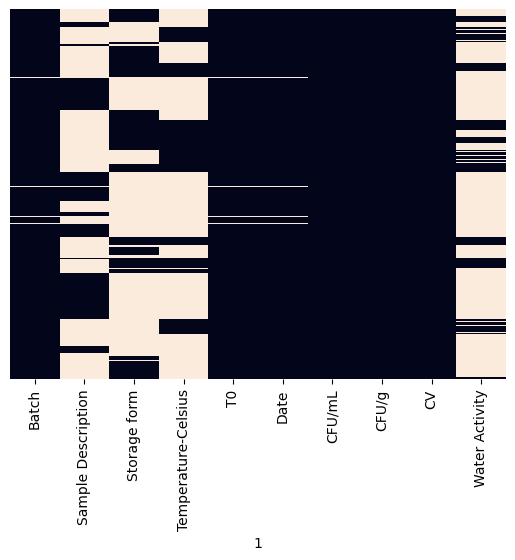

In [5]:
# check NaN values
sns.heatmap(rawcfu_df.isnull(), yticklabels=False, cbar=False)

(401, 10)

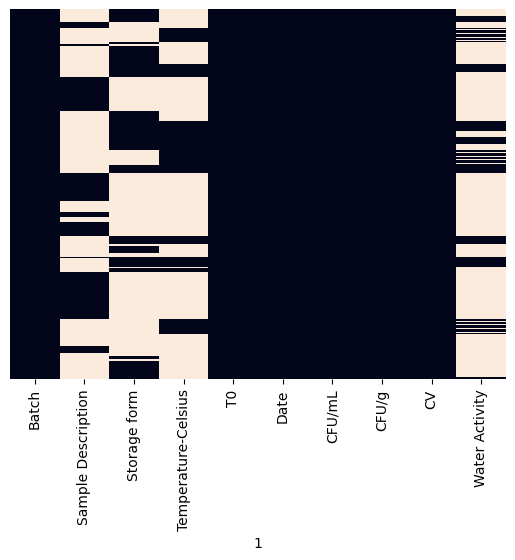

In [6]:
# remove rows with NaN in 'Batch" col
rawcfu_df.dropna(subset=['Batch'],inplace=True)
sns.heatmap(rawcfu_df.isnull(), yticklabels=False, cbar=False)
rawcfu_df.shape

# NaN in CFU/mL or CFU/g indicate either the samples in liq or sol form

In [7]:
rawcfu_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 0 to 404
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Batch                401 non-null    object
 1   Sample Description   154 non-null    object
 2   Storage form         157 non-null    object
 3   Temperature-Celsius  128 non-null    object
 4   T0                   401 non-null    object
 5   Date                 401 non-null    object
 6   CFU/mL               401 non-null    object
 7   CFU/g                401 non-null    object
 8   CV                   401 non-null    object
 9   Water Activity       101 non-null    object
dtypes: object(10)
memory usage: 34.5+ KB


In [8]:
# convert to datetime for T0 and Date
rawcfu_df[['T0','Date']] = rawcfu_df[['T0','Date']].apply(pd.to_datetime, format="%m/%d/%y")

In [9]:
rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.14E+09,4.07E+10,27.80%,NaN
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.52E+09,6.69E+10,4.80%,NaN
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.58E+10,3.00E+11,1.80%,NaN
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.10E+09,5.89E+10,13.70%,NaN
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.36E+10,6.38E+11,10.10%,NaN


In [10]:
# calculate the time point of plating
## the difference 'Date'-'T0' is a 'timedelta'
rawcfu_df['Time point (day)'] = (rawcfu_df['Date']-rawcfu_df['T0']).apply(lambda x: x.days)
rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity,Time point (day)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.14E+09,4.07E+10,27.80%,NaN,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.52E+09,6.69E+10,4.80%,NaN,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.58E+10,3.00E+11,1.80%,NaN,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.10E+09,5.89E+10,13.70%,NaN,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.36E+10,6.38E+11,10.10%,NaN,0


In [11]:
# calculate time point in week
## cant' call .days or .week on timedelta. 
## So, I have to convert each dat to week of the year first before calculating the difference
to_week = rawcfu_df[['T0','Date']]

In [12]:
rawcfu_df['Date'].iloc[0].week - rawcfu_df['T0'].iloc[0].week

0

In [13]:
to_week.columns

Index(['T0', 'Date'], dtype='object', name=1)

In [14]:
for i in to_week.columns:
    to_week[i] = to_week[i].apply(lambda x:x.week)

In [15]:
rawcfu_df['Time point (week)'] = to_week['Date'] - to_week['T0']

In [16]:
rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity,Time point (day),Time point (week)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.14E+09,4.07E+10,27.80%,NaN,0,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.52E+09,6.69E+10,4.80%,NaN,0,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.58E+10,3.00E+11,1.80%,NaN,0,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.10E+09,5.89E+10,13.70%,NaN,0,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.36E+10,6.38E+11,10.10%,NaN,0,0


In [17]:
# Change data type of CFU/mL 
rawcfu_df['CFU/mL'] = rawcfu_df['CFU/mL'].astype(float)

In [18]:
# invalid values (not scientific) in CFU/g col
rawcfu_df.loc[rawcfu_df['CFU/g'] == '#DIV/0!'].index

Int64Index([ 75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
            ...
            330, 331, 332, 333, 334, 335, 336, 337, 338, 339],
           dtype='int64', length=139)

In [19]:
# replace invalid values with NaN
rawcfu_df['CFU/g'] = rawcfu_df['CFU/g'].replace('#DIV/0!', np.NaN)

In [20]:
# Change data type of CFU/g to float
rawcfu_df['CFU/g'] = rawcfu_df['CFU/g'].astype(float)

In [21]:
# Change data type of CV to float
## convert each value to float without the % sign and ignore invalid values
for idx, row in rawcfu_df.iterrows():
    try:
        rawcfu_df.loc[idx, "CV"] = float(row['CV'].split("%")[0])
    except Exception as e:
        pass

In [22]:
## replace invalid values with NaN
rawcfu_df['CV'] = rawcfu_df['CV'].replace('#DIV/0!', np.NaN)

In [23]:
rawcfu_df

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity,Time point (day),Time point (week)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.140000e+09,4.070000e+10,27.8,NaN,0,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.520000e+09,6.690000e+10,4.8,NaN,0,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.580000e+10,3.000000e+11,1.8,NaN,0,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.100000e+09,5.890000e+10,13.7,NaN,0,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.360000e+10,6.380000e+11,10.1,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
400,EDKOKO02222302,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,3.560000e+08,6.760000e+09,13.2,NaN,0,0
401,FDL-105K-T42,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,4.030000e+08,7.650000e+09,10.3,NaN,0,0
402,FDL-105K-T44,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,1.130000e+08,2.150000e+09,1.7,NaN,0,0
403,FDL-105EF-T24 TMC1,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,1.570000e+09,2.990000e+10,4.8,0.298,0,0


<Axes: xlabel='1'>

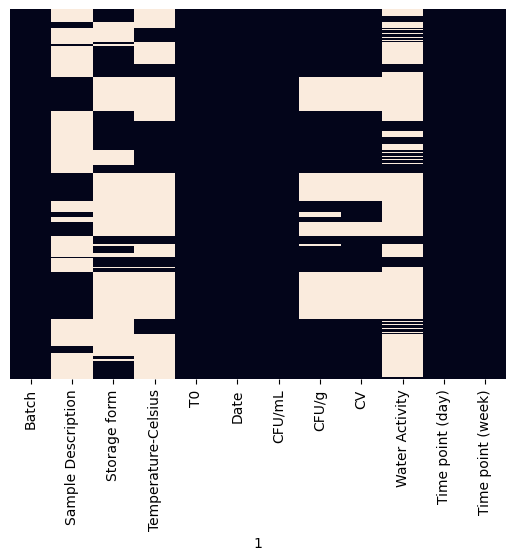

In [24]:
sns.heatmap(rawcfu_df.isnull(), yticklabels=False, cbar=False)

In [25]:
rawcfu_df.info()
# Keep Temp in str for visualization purpose

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 0 to 404
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Batch                401 non-null    object        
 1   Sample Description   154 non-null    object        
 2   Storage form         157 non-null    object        
 3   Temperature-Celsius  128 non-null    object        
 4   T0                   401 non-null    datetime64[ns]
 5   Date                 401 non-null    datetime64[ns]
 6   CFU/mL               401 non-null    float64       
 7   CFU/g                262 non-null    float64       
 8   CV                   269 non-null    float64       
 9   Water Activity       101 non-null    object        
 10  Time point (day)     401 non-null    int64         
 11  Time point (week)    401 non-null    int64         
dtypes: datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 56.9+ KB


In [26]:
# Change Water Activity to float
rawcfu_df['Water Activity'] = rawcfu_df['Water Activity'].astype(float)

In [27]:
# Change col names
rawcfu_df.rename(columns={'Batch':'FD Run ID', 'CV':'CV (%)'}, inplace=True)
rawcfu_df.head()

1,FD Run ID,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.140000e+09,4.070000e+10,27.8,NaN,0,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.520000e+09,6.690000e+10,4.8,NaN,0,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.580000e+10,3.000000e+11,1.8,NaN,0,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.100000e+09,5.890000e+10,13.7,NaN,0,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.360000e+10,6.380000e+11,10.1,NaN,0,0


In [28]:
rawcfu_df.rename(columns={'Temperature-Celsius':'Temperature (C)'}, inplace=True)
rawcfu_df.head()

1,FD Run ID,Sample Description,Storage form,Temperature (C),T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.140000e+09,4.070000e+10,27.8,NaN,0,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.520000e+09,6.690000e+10,4.8,NaN,0,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.580000e+10,3.000000e+11,1.8,NaN,0,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.100000e+09,5.890000e+10,13.7,NaN,0,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.360000e+10,6.380000e+11,10.1,NaN,0,0


### Data cleaning steps

In [2]:
# Import the dataset
rawcfu_df = pd.read_csv(filepath_or_buffer="Data files/Pivot_CFUs_Test1.csv")

In [3]:
# replace the colmns with the values of the second row
rawcfu_df.columns = rawcfu_df.iloc[1]
# remove the first and second rows
rawcfu_df = rawcfu_df.iloc[2:]
# reset index
rawcfu_df = rawcfu_df.reset_index()
# keep relevant cols
rawcfu_df = rawcfu_df[['Batch','Sample Description','Storage form','Temperature-Celsius',
                       'T0','Date','CFU/mL','CFU/g','Extender CFU/mL','Extender CFU/mL SD',
                       'CV','Water Activity']]
# remove rows with NaN in 'Batch" col
rawcfu_df.dropna(subset=['Batch'],inplace=True)


# convert to datetime for T0 and Date
rawcfu_df[['T0','Date']] = rawcfu_df[['T0','Date']].apply(pd.to_datetime, format="%m/%d/%y")

# calculate the time point of plating
## by days
rawcfu_df['Time point (day)'] = (rawcfu_df['Date']-rawcfu_df['T0']).apply(lambda x: x.days)
## by weeks   
def num_weeks(row):
        year1, week1, day1 = row['T0'].isocalendar()
        year2, week2, day2 = row['Date'].isocalendar()
        return (year2 - year1) * 52 + (week2 - week1)

# apply the function to each row of the DataFrame
rawcfu_df['Time point (week)'] = rawcfu_df.apply(num_weeks, axis=1)

# remove percentage sign for CV values while ignoring invalid values
for idx, row in rawcfu_df.iterrows():
    try:
        rawcfu_df.loc[idx, "CV"] = float(row['CV'].split("%")[0])
    except Exception as e:
        pass

# handle invalid values and change to float
to_float = rawcfu_df[['CFU/mL','CFU/g','Water Activity']]
for col in to_float.columns:
    rawcfu_df[col] = rawcfu_df[col].replace('#DIV/0!', np.NaN)
    rawcfu_df[col] = rawcfu_df[col].astype(float)
    
    
# Change col names
rawcfu_df.rename(columns={'Batch':'FD Run ID', 'Temperature-Celsius':'Temperature (C)', 'CV':'CV (%)'}, inplace=True)

In [4]:
rawcfu_df.head()

1,FD Run ID,Sample Description,Storage form,Temperature (C),T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,7.410000e+08,1.410000e+10,8.6,0.254,53,8
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,1.970000e+09,3.750000e+10,10.0,0.198,53,8
2,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-02-27,1.250000e+10,2.380000e+11,20.3,NaN,53,8
3,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,4.550000e+08,8.640000e+09,7.9,0.267,53,8
4,IFF09152022-3 T1,NaN,NaN,21,2023-01-05,2023-02-27,2.440000e+08,4.640000e+09,4.3,0.227,53,8


In [5]:
rawcfu_df.shape

(65, 12)

In [6]:
rawcfu_df['FD Run ID'].nunique()

61

## B. Data Processing

One sample can be in different storage form: bulk powder, pellet. Each will have a unique 'FD Run ID'
- **ISSUE: Naming for unique ID**
    Each 'FD Run ID' is not unique because:
    - one sample is submitted to different temperatures
    - one sample is stored in different form
- Arrange the CFU of each sample by Timepoint (week) (axis =1) (pivot table)
- Join new CFU data for each time point, axis =1
    - make sure there are only unique IDs (aka shape of pivot table)
    - remove 'T0','Date','CV' from rawcfu_df becasue it they make the some samples carry distinguish info (e.g. one sample with W0, W8 but different CV and Date -> the rows stay

In [83]:
# Record the CFUs by week for each ID
pivot_rawcfu = rawcfu_df.pivot(index='FD Run ID', columns='Time point (week)', values=['CFU/mL','CFU/g'])

In [84]:
pivot_rawcfu

CFU/mL                           CFU/g      \
Time point (week)               0   1             8             0   1   
FD Run ID                                                               
ABKLUB 030823AA      2.120000e+10 NaN           NaN  4.030000e+11 NaN   
ABKLUB 031023AA      2.250000e+10 NaN           NaN  4.280000e+11 NaN   
ABKLUB 031323AA      2.400000e+10 NaN           NaN  4.560000e+11 NaN   
ABKLUB 031623AA #9   2.960000e+10 NaN           NaN  5.620000e+11 NaN   
ABKLUB 031823AA #10  2.530000e+10 NaN           NaN  4.810000e+11 NaN   
...                           ...  ..           ...           ...  ..   
IFF10202022-1 T4              NaN NaN  7.170000e+07           NaN NaN   
IFF10202022-2 T1              NaN NaN  7.730000e+06           NaN NaN   
IFF10202022-2 T2              NaN NaN  1.050000e+07           NaN NaN   
IFF10202022-2 T3              NaN NaN  2.730000e+09           NaN NaN   
IFF10202022-2 T4              NaN NaN  4.130000e+06           NaN NaN   

                                   
Time point (week)               8  
FD Run ID                          
ABKLUB 030823AA               NaN  
ABKLUB 031023AA               NaN  
ABKLUB 031323AA               NaN  
ABKLUB 031623AA #9            NaN  
ABKLUB 031823AA #10           NaN  
...                           ...  
IFF10202022-1 T4     1.360000e+09  
IFF10202022-2 T1     1.470000e+08  
IFF10202022-2 T2     2.000000e+08  
IFF10202022-2 T3     5.190000e+10  
IFF10202022-2 T4     7.850000e+07  

[61 rows x 6 columns]

In [ ]:
# write to excel. Gives expected format
pivot_rawcfu.to_excel('CFU_cleaned.xlsx')

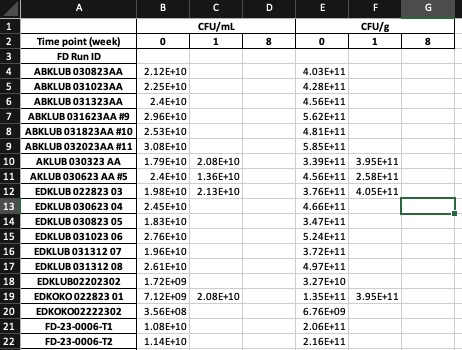

In [28]:
pivot_rawcfu.loc['AKLUB 030323 AA']

        Time point (week)
CFU/mL  0                    1.790000e+10
        1                    2.080000e+10
        8                             NaN
CFU/g   0                    3.390000e+11
        1                    3.950000e+11
        8                             NaN
Name: AKLUB 030323 AA, dtype: float64

In [29]:
pivot_rawcfu.columns.to_list()

[('CFU/mL', 0),
 ('CFU/mL', 1),
 ('CFU/mL', 8),
 ('CFU/g', 0),
 ('CFU/g', 1),
 ('CFU/g', 8)]

In [85]:
# rename the column by the counting week
pivot_rawcfu.columns = [f"W{week}_{scale}" for scale, week in pivot_rawcfu.columns.to_list()]

In [100]:
# remove cols that cause repeated samples
cfu = rawcfu_df.drop(['T0','Date','CFU/mL','CFU/g','CV (%)','Time point (day)','Time point (week)'],axis=1)

In [101]:
cfu.head()

1,FD Run ID,Sample Description,Storage form,Temperature (C),Water Activity
0,IFF09152022-2 T1,NaN,NaN,21,0.254
1,IFF09152022-2 T2,NaN,NaN,21,0.198
2,IFF09152022-2 T3,NaN,NaN,4,NaN
3,IFF09152022-2 T4,NaN,NaN,21,0.267
4,IFF09152022-3 T1,NaN,NaN,21,0.227


In [102]:
cfu.shape, pivot_rawcfu.shape

((65, 5), (61, 6))

In [103]:
cfu[cfu.duplicated('FD Run ID')]

1,FD Run ID,Sample Description,Storage form,Temperature (C),Water Activity
25,AKLUB 030623 AA #5,NaN,NaN,NaN,NaN
26,AKLUB 030323 AA,NaN,NaN,NaN,NaN
27,EDKOKO 022823 01,NaN,NaN,NaN,NaN
28,EDKLUB 022823 03,NaN,NaN,NaN,NaN


In [104]:
cfu.drop_duplicates(subset='FD Run ID', inplace=True)

In [105]:
cfu.shape

(61, 5)

In [106]:
joined_df = pd.merge(cfu, pivot_rawcfu, on='FD Run ID')

In [107]:
joined_df.head()

,FD Run ID,Sample Description,Storage form,Temperature (C),Water Activity,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W8_CFU/g
0,IFF09152022-2 T1,NaN,NaN,21,0.254,NaN,NaN,7.410000e+08,NaN,NaN,1.410000e+10
1,IFF09152022-2 T2,NaN,NaN,21,0.198,NaN,NaN,1.970000e+09,NaN,NaN,3.750000e+10
2,IFF09152022-2 T3,NaN,NaN,4,NaN,NaN,NaN,1.250000e+10,NaN,NaN,2.380000e+11
3,IFF09152022-2 T4,NaN,NaN,21,0.267,NaN,NaN,4.550000e+08,NaN,NaN,8.640000e+09
4,IFF09152022-3 T1,NaN,NaN,21,0.227,NaN,NaN,2.440000e+08,NaN,NaN,4.640000e+09


In [108]:
joined_df.shape

(61, 11)

In [109]:
rawcfu_df.shape, pivot_rawcfu.shape, joined_df.shape

((65, 12), (61, 6), (61, 11))

The key information from this table is:
- FD Run ID: these must be unique and implemented soon for the program to work properly
- CFUs by weeks 

It's possible for the CFUs data to collected in 1 file as the df will be replaced and updated each time. The code will work as expected without concatenating the new info. 

The next steps are to:
- join this table to the master list
- relate to on-seed samples
- relate to sample information sheet (?)

### Data Processing Step

In [7]:
# Record the CFUs by week for each ID
pivot_rawcfu = rawcfu_df.pivot(index='FD Run ID', columns='Time point (week)', values=['CFU/mL','CFU/g'])
# rename the column by the counting week
pivot_rawcfu.columns = [f"W{week}_{scale}" for scale, week in pivot_rawcfu.columns.to_list()]

# remove cols that cause repeated samples
cfu = rawcfu_df.drop(['T0','Date','CFU/mL','CFU/g','CV (%)','Time point (day)','Time point (week)'],axis=1)
# drop duplicated IDs
cfu.drop_duplicates(subset='FD Run ID', inplace=True)

# join the pivot df with the original info
cleaned_cfu = pd.merge(cfu, pivot_rawcfu, on='FD Run ID')

In [8]:
cleaned_cfu.head()

,FD Run ID,Sample Description,Storage form,Temperature (C),Water Activity,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W8_CFU/g
0,IFF09152022-2 T1,NaN,NaN,21,0.254,NaN,NaN,7.410000e+08,NaN,NaN,1.410000e+10
1,IFF09152022-2 T2,NaN,NaN,21,0.198,NaN,NaN,1.970000e+09,NaN,NaN,3.750000e+10
2,IFF09152022-2 T3,NaN,NaN,4,NaN,NaN,NaN,1.250000e+10,NaN,NaN,2.380000e+11
3,IFF09152022-2 T4,NaN,NaN,21,0.267,NaN,NaN,4.550000e+08,NaN,NaN,8.640000e+09
4,IFF09152022-3 T1,NaN,NaN,21,0.227,NaN,NaN,2.440000e+08,NaN,NaN,4.640000e+09


In [9]:
cleaned_cfu.shape

(61, 11)

In [ ]:
cleaned_cfu.to_excel('CFU_cleaned.xlsx')

## Function

In [14]:
# Import the dataset
data = pd.read_csv(filepath_or_buffer="Data files/Pivot_CFUs_Template.csv")

In [15]:
def pivot_in_pack(df):
    rawcfu_df = df
    rawcfu_df.columns = rawcfu_df.iloc[1]
    rawcfu_df = rawcfu_df.iloc[2:]
    rawcfu_df = rawcfu_df.reset_index()
    # remove rows with NaN in 'Batch" col
    rawcfu_df.dropna(subset=['Batch'],inplace=True)
    # remove rows with 'Redo' in 'Remark' col
    rawcfu_df.drop(rawcfu_df[rawcfu_df['Remark/AW'] == 'Redo'].index, inplace=True)
    # keep relevant cols
    rawcfu_df = rawcfu_df[['Batch','Sample Description','Storage form','Temperature-Celsius',
                           'T0','Date','CFU/mL','Extender CFU/mL','Extender CFU/mL SD','CFU/g',
                           'CV','Water Activity']]
    
    # convert to datetime for T0 and Date
    rawcfu_df[['T0','Date']] = rawcfu_df[['T0','Date']].apply(pd.to_datetime, format="%m/%d/%y")
    
    # calculate the time point by days and weeks of plating
    ## by days
    rawcfu_df['Time point (day)'] = np.absolute((rawcfu_df['Date']-rawcfu_df['T0'])).apply(lambda x: x.days)
    ## by weeks
    #df['Time point (week)'] = df['T0'].apply(lambda x: x.week) - df['Date'].apply(lambda x: x.week)
    def num_weeks(row):
        year1, week1, day1 = row['T0'].isocalendar()
        year2, week2, day2 = row['Date'].isocalendar()
        return (year2 - year1) * 52 + (week2 - week1)

    # apply the function to each row of the DataFrame
    rawcfu_df['Time point (week)'] = rawcfu_df.apply(num_weeks, axis=1)    
    
    # remove percentage sign for CV values while ignoring invalid values
    for idx, row in rawcfu_df.iterrows():
        try:
            rawcfu_df.loc[idx, "CV"] = float(row['CV'].split("%")[0])
        except Exception as e:
            pass
    
    # handle invalid values and change to float
    to_float = rawcfu_df[['CFU/mL','CFU/g','Extender CFU/mL','Extender CFU/mL SD','Water Activity']]
    for col in to_float.columns:
        rawcfu_df[col] = rawcfu_df[col].replace('#DIV/0!', np.NaN)
        rawcfu_df[col] = rawcfu_df[col].astype(float)      
        
    # change col names
    rawcfu_df.rename(columns={'Batch':'FD Run ID', 'Temperature-Celsius':'Temperature (C)', 'CV':'CV (%)'}, inplace=True)
    
    # Record the CFUs by week for each ID
    pivot_rawcfu = rawcfu_df.pivot(
        index='FD Run ID', columns='Time point (week)',
        values=['CFU/mL','CFU/g','Extender CFU/mL','Extender CFU/mL SD','Water Activity'])
    # rename the column by the counting week
    pivot_rawcfu.columns = [f"W{week}_{scale}" for scale, week in pivot_rawcfu.columns.to_list()]
    
    # remove cols that cause repeated samples
    cfu = rawcfu_df.drop(
        ['CFU/mL','CFU/g','CV (%)','Extender CFU/mL','Extender CFU/mL SD',
         'Water Activity','Time point (day)','Time point (week)'],axis=1)
    # drop duplicated IDs
    cfu.drop_duplicates(subset='FD Run ID', inplace=True)
    
    # join the pivot df with the original info
    cleaned_cfu = pd.merge(cfu, pivot_rawcfu, on='FD Run ID')
    
    return rawcfu_df, cleaned_cfu

In [4]:
pivot_in_pack(data)

(1            FD Run ID Sample Description   Storage form Temperature (C)  \
 0     IFF09152022-2 T1                NaN            NaN              21   
 1     IFF09152022-2 T2                NaN            NaN              21   
 2     IFF09152022-2 T3                NaN            NaN               4   
 3     IFF09152022-2 T4                NaN            NaN              21   
 4     IFF09152022-3 T1                NaN            NaN              21   
 ..                 ...                ...            ...             ...   
 60      EDKOKO02222302                NaN  Bulked powder             NaN   
 61        FDL-105K-T42                NaN  Bulked powder             NaN   
 62        FDL-105K-T44                NaN  Bulked powder             NaN   
 63  FDL-105EF-T24 TMC1                NaN  Bulked powder             NaN   
 64  FDL-105EF-T24 TMC2                NaN  Bulked powder             NaN   
 
 1          T0       Date        CFU/mL         CFU/g  CV (%)  Water Activ

In [16]:
raw, clean = pivot_in_pack(data)

In [17]:
raw.head()

1,FD Run ID,Sample Description,Storage form,Temperature (C),T0,Date,CFU/mL,Extender CFU/mL,Extender CFU/mL SD,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,7.410000e+08,NaN,NaN,1.410000e+10,8.6,0.254,53,8
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,1.970000e+09,NaN,NaN,3.750000e+10,10.0,0.198,53,8
3,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-03-01,2.300000e+01,NaN,NaN,4.500000e+00,8.6,NaN,55,8
4,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,4.550000e+08,NaN,NaN,8.640000e+09,7.9,0.267,53,8
5,IFF09152022-3 T1,NaN,NaN,21,2023-01-05,2023-02-27,2.440000e+08,NaN,NaN,4.640000e+09,4.3,0.227,53,8


In [18]:
raw.tail()

1,FD Run ID,Sample Description,Storage form,Temperature (C),T0,Date,CFU/mL,Extender CFU/mL,Extender CFU/mL SD,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
67,FDL-105D-T20-W4,Extender,NaN,NaN,2022-10-12,2023-02-09,NaN,2.600000e+09,80000000.0,NaN,3.1,NaN,120,17
68,FDL-105C-T14-W4,Extender,NaN,NaN,2022-10-12,2023-02-09,NaN,4.670000e+09,231000000.0,NaN,4.9,NaN,120,17
69,FDL-105C-T11-W4,Extender,NaN,NaN,2022-10-12,2023-02-09,NaN,1.390000e+09,205000000.0,NaN,14.8,NaN,120,17
70,FDL-105B-T10-W4,Extender,NaN,NaN,2022-10-12,2023-02-09,NaN,1.110000e+09,241000000.0,NaN,21.8,NaN,120,17
71,FD-23-0006-T3,NaN,NaN,NaN,2023-03-13,2023-03-15,1.720000e+09,NaN,NaN,3.770000e+11,15.7,NaN,2,0


In [19]:
clean.head()

,FD Run ID,Sample Description,Storage form,Temperature (C),T0,Date,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W17_CFU/mL,...,W8_Extender CFU/mL,W17_Extender CFU/mL,W0_Extender CFU/mL SD,W1_Extender CFU/mL SD,W8_Extender CFU/mL SD,W17_Extender CFU/mL SD,W0_Water Activity,W1_Water Activity,W8_Water Activity,W17_Water Activity
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,NaN,NaN,7.410000e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254,NaN
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,NaN,NaN,1.970000e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.198,NaN
2,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-03-01,NaN,NaN,2.300000e+01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,NaN,NaN,4.550000e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.267,NaN
4,IFF09152022-3 T1,NaN,NaN,21,2023-01-05,2023-02-27,NaN,NaN,2.440000e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.227,NaN


In [20]:
raw.shape, clean.shape

((70, 14), (66, 26))

---

## Appendices

**Tranpose columns to rows**

In [19]:
# create a sample dataframe
data = {'Name': ['John', 'Mary', 'Peter'],
        'Age': [25, 30, 35],
        'Salary_2019': [50000, 60000, 70000],
        'Salary_2020': [55000, 65000, 75000],
        'Salary_2021': [60000, 70000, 80000]}

df = pd.DataFrame(data)

# melt the data to transpose columns to rows
melted_df = pd.melt(df, id_vars=['Name', 'Age'], var_name='Year', value_name='Salary')

# print the transposed dataframe
print(melted_df)

    Name  Age         Year  Salary
0   John   25  Salary_2019   50000
1   Mary   30  Salary_2019   60000
2  Peter   35  Salary_2019   70000
3   John   25  Salary_2020   55000
4   Mary   30  Salary_2020   65000
5  Peter   35  Salary_2020   75000
6   John   25  Salary_2021   60000
7   Mary   30  Salary_2021   70000
8  Peter   35  Salary_2021   80000


In [20]:
df

,Name,Age,Salary_2019,Salary_2020,Salary_2021
0,John,25,50000,55000,60000
1,Mary,30,60000,65000,70000
2,Peter,35,70000,75000,80000


**Tranpose rows to columns**

In [22]:
# create a sample dataframe
data = {'Name': ['John', 'Mary', 'Peter'],
        'Year': [2019, 2020, 2021],
        'Salary': [50000, 60000, 70000]}

df1 = pd.DataFrame(data)

# pivot the data to transpose rows to columns
pivoted_df = df1.pivot(index='Name', columns='Year', values='Salary')

# print the transposed dataframe
print(pivoted_df)

Year      2019     2020     2021
Name                            
John   50000.0      NaN      NaN
Mary       NaN  60000.0      NaN
Peter      NaN      NaN  70000.0


In [23]:
df1

,Name,Year,Salary
0,John,2019,50000
1,Mary,2020,60000
2,Peter,2021,70000


In [12]:
import pandas as pd

# Create a sample DataFrame and pivot table
df = pd.DataFrame({'A': [1, 2, 3], 'B': ['a', 'b', 'c']}, index=['X', 'Y', 'Z'])
pivot_table = pd.pivot_table(df, values='A', index='B', aggfunc='sum')

# Join the pivot table with the original DataFrame
joined_df = df.join(pivot_table, on='B', rsuffix='_sum')

# Display the joined DataFrame
print(joined_df)

   A  B  A_sum
X  1  a      1
Y  2  b      2
Z  3  c      3


In [13]:
df

,A,B
X,1,a
Y,2,b
Z,3,c


In [14]:
pivot_table

,A
B,
a,1
b,2
c,3


In [75]:
import pandas as pd

# create a pivot table
df_pivot = pd.DataFrame({'A': ['foo', 'foo', 'bar', 'bar', 'foo', 'foo', 'bar', 'bar'],
                         'B': ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two'],
                         'C': [1, 2, 3, 4, 5, 6, 7, 8],
                         'D': [10, 20, 30, 40, 50, 60, 70, 80]}).pivot_table(index='A', columns='B', values='C')

# create a regular DataFrame
df_normal = pd.DataFrame({'A': ['foo', 'bar', 'baz'], 'E': [100, 200, 300]})

# reset the index of the pivot DataFrame
df_pivot = df_pivot.reset_index()

# join the two DataFrames on the 'A' column
df_merged = pd.merge(df_pivot, df_normal, on='A')

print(df_merged)

     A  one  two    E
0  bar    5    6  200
1  foo    3    4  100


In [76]:
df_pivot

B,A,one,two
0,bar,5,6
1,foo,3,4


In [77]:
df_normal

,A,E
0,foo,100
1,bar,200
2,baz,300
